#                            IMAGE CAPTION GENERATOR PROJECT
#  
#  



In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import nltk

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# all necessary imports 

import pandas as pd
import numpy as np
import os
import cv2
import nltk
from nltk.tokenize import word_tokenize
import string
from os import listdir
from pickle import dump
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model
from os import listdir
from PIL import Image as PImage
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras import models
from keras.models import load_model

In [6]:
# loads and returns a text file

def read_file(filename):
    
    file = open(filename,'r')
    doc = file.read().splitlines()
    
    return doc

In [7]:
# creates a dictionary ('descriptions') with key as image name and values as a list of 5 captions and returns it

def create_descriptions(filename):
    
    doc = read_file(filename)
    
    descriptions = {}
    
    for each_line in doc:
        key = each_line.split('\t')[0][:-2]
        value = each_line.split('\t')[1]
        if key not in descriptions:
            descriptions[key] = list()
        descriptions[key].append(value)
        
    return descriptions

In [8]:
# helper function
# performs validity checks for data cleaning
# returns false for single letters and words with numbers

def is_valid(token):
    
    if len(token) <= 1:
        return False
    
    for ch in range(len(token)):
        if token[ch] >= '0' and token[ch] <= '9':
            return False

    return True

In [9]:
# helper function
# removes punctuations from words

def remove_punctuations(token):
    
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    word = ""
    
    for char in token:
        if char not in punctuations:
            word = word + char
        
    return word

In [10]:
# performs cleaning on descriptions and returns it.

def get_cleaned_descriptions(descriptions):
    
    cleaned_descriptions = {}
    
    for key in descriptions:
        sample = []
        
        for caption in descriptions[key]:
            tokens = word_tokenize(caption)
            words = []
            
            for token in tokens:
                if is_valid(token):
                    token = remove_punctuations(token)
                    words.append(token.lower())
                    
            sample.append(" ".join(words))
            
        cleaned_descriptions[key] = sample

    return cleaned_descriptions

In [11]:
def create_vocabulary(descriptions, threshold_freq):
    
    # creating a vocabulary

    vocabulary = set()

    for key in descriptions:
        for caption in descriptions[key]:
            tokens = word_tokenize(caption)
            for token in tokens:
                vocabulary.add(token)

    print("Total number of unique words : ", len(vocabulary))
    
    #now to find words with occurences > threshold_freq

    freq = dict()
    for key in descriptions:
        for caption in descriptions[key]:
            tokens = word_tokenize(caption)
            for word in tokens:
                if word in freq:
                    freq[word] = freq[word] + 1
                else:
                    freq[word] = 1
    
    vocabulary = []

    for key in freq:
        if freq[key] > threshold_freq:
            vocabulary.append(key)

    print("The length of the vocabulary is : ", len(vocabulary))
    
    return vocabulary


In [12]:
# picks captions for training images from descriptions and stores it in train_desctiptions dictionary.

def get_train_test_descriptions(filename, descriptions):
    
    images_name = read_file(filename)
    
    train_descriptions = {}
    
    for img in images_name:
        
        key = img.split('.')[0]
            
        train_descriptions[key] = list()
            
        for caption in descriptions[img]:
            
            line = caption.split()
            new_line = 'startseq ' + ' '.join(line) + ' endseq'
            
            
            train_descriptions[key].append(new_line)        
        
    return train_descriptions

In [ ]:
# feature extraction of images

def extract_features(directory):
    
    model = VGG16()
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    print(model.summary())
    features=dict()
    
    for name in listdir(directory):
        
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224,224))
        image = img_to_array(image)
        image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image,verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s'%name)
        
    return features


In [13]:
# load  training photo features
def load_photo_features(filename, labels_file):
    
    images_name = read_file(labels_file)
    
    for i in range(len(images_name)):
        
        images_name[i] = images_name[i].split('.')[0]
    
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in images_name}
    return features


In [14]:
def convert_to_lines(descriptions):
    all_lines = list()
    for key in descriptions.keys():
        [all_lines.append(d) for d in descriptions[key]]
    return all_lines

In [15]:
def create_tokenizer(descriptions):
    
    all_lines = convert_to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_lines)
    return tokenizer

In [16]:
def get_max_length(descriptions):
    
    all_lines = convert_to_lines(descriptions)
    max_len = 0
    for line in all_lines:
        line = line.split()
        max_len = max(max_len,len(line))
    return max_len

In [17]:
# file path for all the captions

filename = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_text_extracted/Flickr8k.token.txt'
# getting descriptions
descriptions = create_descriptions(filename)

# getting cleaned descriptions
descriptions = get_cleaned_descriptions(descriptions)

In [18]:
# preparing train_descriptions and train_features

train_text_file = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_text_extracted/Flickr_8k.trainImages.txt'

# train_descripitons contain captions of training images(dictionary). 

train_descriptions = get_train_test_descriptions(train_text_file,descriptions)

filename = '/content/drive/MyDrive/Colab Notebooks/features.pkl'
labels_file = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_text_extracted/Flickr_8k.trainImages.txt'

train_features = load_photo_features(filename, labels_file)

In [19]:
threshold_freq = 0

vocabulary = create_vocabulary(descriptions,threshold_freq)

Total number of unique words :  8766
The length of the vocabulary is :  8766


In [ ]:

directory = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_Dataset_extracted/Flicker8k_Dataset'
features = extract_features(directory)
print('Extrated Features: %d' % len(features))
dump(features,open('features.pkl','wb'))

In [20]:
print("Length of train_descriptions : ",len(train_descriptions))
print("Length of train_features : ",len(train_features))

Length of train_descriptions :  6000
Length of train_features :  6000


In [21]:
# validation set


validation_text_file = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_text_extracted/Flickr_8k.devImages.txt'
validation_descriptions = get_train_test_descriptions(validation_text_file,descriptions)

filename = '/content/drive/MyDrive/Colab Notebooks/features.pkl'
labels_file = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_text_extracted/Flickr_8k.devImages.txt'

validation_features = load_photo_features(filename, labels_file)


In [22]:
validation_descriptions['3425756814_13909354d4']


['startseq male tennis player holding his tennis racket endseq',
 'startseq man holding tennis racket is looking in the distance with his hand over his mouth endseq',
 'startseq man in sleeveless blue tennis shirt blows kisses to the fans endseq',
 'startseq tennis player holds one hand to his mouth and the other holds racket endseq',
 'startseq tennis player in green striped shirt is holding his hand up to his mouth endseq']

In [23]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7581


In [24]:
max_length = get_max_length(train_descriptions)
print("The maximum number of words in a caption is : ",max_length)

The maximum number of words in a caption is :  34


In [ ]:
def generate_input_output_data(tokenizer, descriptions, image, max_length, vocab_size):
    
    X1 = [] # for images
    X2 = [] # for captions
    Y = [] # for next word (output)
        
    for line in descriptions:

        line = tokenizer.texts_to_sequences([line])[0]

        for i in range(1,len(line)):

            inp_line = line[ : i]
            op_line = line[i]
            inp_line = pad_sequences([inp_line], maxlen = max_length)[0]
            op_line = to_categorical([op_line], num_classes = vocab_size)[0]

            X1.append(image)
            X2.append(inp_line)
            Y.append(op_line)
    
    X1 = np.array(X1)
    X2 = np.array(X2)
    Y = np.array(Y)

    return X1, X2, Y
        

In [ ]:
def data_generator(descriptions, images, tokenizer, max_length, vocab_size):
    
    while True:
        
        for key,caption_list in descriptions.items():
            
            image = images[key][0]
            X1, X2, Y = generate_input_output_data(tokenizer,caption_list,image,max_length,vocab_size)
            
            yield [X1,X2], Y
        

In [ ]:
# testing the generator function

generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 34)
(47, 7581)


In [ ]:
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(34,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
# define the model
model = define_model(vocab_size, 34)
# train the model, run epochs manually and save after each epoch
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940736     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 1688s 281ms/step - loss: 3.1753


In [25]:

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [26]:
def generate_descriptions(model, max_length, tokenizer, image):

  caption = "startseq"
  for i in range(max_length):

    
    line = tokenizer.texts_to_sequences([caption])[0]
    line = pad_sequences([line],maxlen = max_length)
    op_word = model.predict([image,line], verbose=0)
    op_word = np.argmax(op_word)
    word = word_for_id(op_word,tokenizer)
    
    if word is None:
     
      continue 
  
    caption = caption + " " + word
    
    if word == 'endseq':
      break
  
  return caption



In [27]:
filename = '/content/drive/MyDrive/model_4.h5'
model = load_model(filename)

In [ ]:
validation_descriptions['1130369873_d80a1aa59c']

['startseq brown dog is running through neckdeep water carrying tennis ball endseq',
 'startseq brown dog splashes in the water while carrying ball in its mouth endseq',
 'startseq brown dog swims through water outdoors with tennis ball in its mouth endseq',
 'startseq red dog holding ball splashes through vegetation filled water endseq',
 'startseq brown dog with tennis ball in mouth in water and bushes endseq']

In [ ]:
validation_features['3103231330_db98b14501']

array([[0.       , 0.       , 0.       , ..., 0.       , 3.4910133,
        1.2707422]], dtype=float32)

In [28]:

def print_photo(path,imgname):
  imgname = imgname + '.jpg'
  img = mpimg.imread(path+imgname)
  imgplot = plt.imshow(img)
  plt.show()

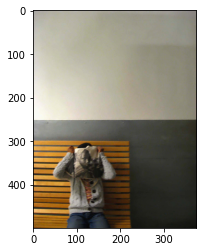

'startseq young boy in blue shirt is jumping into pool endseq'

In [34]:
filename = '/content/drive/MyDrive/Colab Notebooks/Flickr8k_Dataset_extracted/Flicker8k_Dataset/'

#560278886_df4bd2e212

image_name = '2474092890_6c0781a8ed'
generated_caption = generate_descriptions(model,34,tokenizer,validation_features[image_name])
print_photo(filename,image_name )
generated_caption

In [ ]:
validation_descriptions

{'2090545563_a4e66ec76b': ['startseq the boy laying face down on skateboard is being pushed along the ground by another boy endseq',
  'startseq two girls play on skateboard in courtyard endseq',
  'startseq two people play on long skateboard endseq',
  'startseq two small children in red shirts playing on skateboard endseq',
  'startseq two young children on skateboard going across sidewalk endseq'],
 '3393035454_2d2370ffd4': ['startseq boy in blue top is jumping off some rocks in the woods endseq',
  'startseq boy jumps off tan rock endseq',
  'startseq boy jumps up in field in the woods endseq',
  'startseq young boy jumps off rock in the forest endseq',
  'startseq child in blue and grey shirt jumping off hill in the woods endseq'],
 '3695064885_a6922f06b2': ['startseq lady walking her dog through an obstacle course while other people are in the background endseq',
  'startseq small tan and white dog and trainer running an obstacle course endseq',
  'startseq woman is guiding brown